In [1]:
!pip install -q numpy pandas matplotlib scikit-learn causalml

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftTreeClassifier
import matplotlib.pyplot as plt

np.random.seed(10)

n = 5000
X1 = np.random.normal(0, 1, n)
X2 = np.random.uniform(0, 1, n)
treatment = np.random.binomial(1, 0.5, n)
# True heterogeneous effect
uplift_true = 2 * X1 - 3 * X2
y = (0.3 * X1 + 0.2 * X2 + 0.1*treatment + 0.5*uplift_true*treatment + np.random.normal(0, 1, n)) > 0.5
y = y.astype(int)

data = pd.DataFrame({'X1': X1, 'X2': X2, 'Treatment': treatment, 'Y': y})
data.head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


,X1,X2,Treatment,Y
0,1.331587,0.536738,1,1
1,0.715279,0.951946,1,1
2,-1.545400,0.127774,1,0
3,-0.008384,0.009468,1,1
4,0.621336,0.361249,0,0


In [4]:
from sklearn.linear_model import LogisticRegression
import numpy as np

X = data[['X1', 'X2']].values
t = data['Treatment'].values
y = data['Y'].values

model_t = LogisticRegression(max_iter=1000, solver='lbfgs')
model_c = LogisticRegression(max_iter=1000, solver='lbfgs')

model_t.fit(X[t == 1], y[t == 1])
model_c.fit(X[t == 0], y[t == 0])

p1 = model_t.predict_proba(X)[:, 1]
p0 = model_c.predict_proba(X)[:, 1]

data['Estimated_Uplift'] = p1 - p0
data[['X1', 'X2', 'Estimated_Uplift']].head()


,X1,X2,Estimated_Uplift
0,1.331587,0.536738,0.263213
1,0.715279,0.951946,-0.188143
2,-1.545400,0.127774,-0.182079
3,-0.008384,0.009468,-0.017543
4,0.621336,0.361249,0.068888


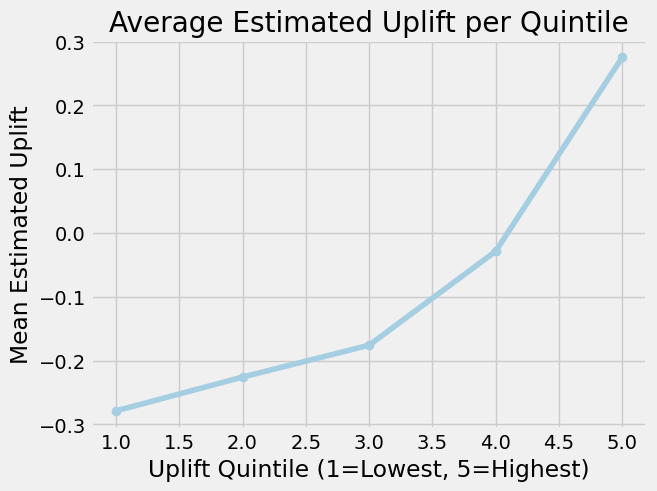

In [5]:
bins = pd.qcut(data['Estimated_Uplift'], q=5, labels=False)
group_means = data.groupby(bins)['Estimated_Uplift'].mean()
plt.plot(range(1,6), group_means, marker='o')
plt.title("Average Estimated Uplift per Quintile")
plt.xlabel("Uplift Quintile (1=Lowest, 5=Highest)")
plt.ylabel("Mean Estimated Uplift")
plt.show()


In [7]:
!pip install -q scikit-uplift

from sklift.metrics import qini_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    data[['X1', 'X2']], data['Y'], data['Treatment'], test_size=0.3, random_state=42
)

qini_value = qini_auc_score(y_test, data.loc[y_test.index, 'Estimated_Uplift'], treat_test)
print("Qini AUC:", qini_value)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.1 MB/s eta 0:00:00
Qini AUC: 0.2516230265492092
